# Final Project on Extracting Stock Sentiment from News Headlines

In [26]:
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import os
import pandas as pd
import matplotlib.pyplot as plt

html_tables = {}

for table_name in os.listdir('datasets'):
    table_path = f'datasets/{table_name}'
    table_file = open(table_path, 'r')
    html = BeautifulSoup(table_file)
    html_table = html.find(id='news-table')
    html_tables[table_name] = html_table

In [17]:
tsla = html_tables['tsla_22sep.html']
# Get all the table rows tagged in HTML with <tr> into 'tesla_tr'
tsla_tr = tsla.findAll('tr')

# For each row...
for i, table_row in enumerate(tsla_tr):
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.a.get_text()
    # Read the text of the element 'td' into 'data_text'
    data_text = table_row.td.get_text()
    # Print the count
    print(f'File number {i+1}:')
    # Print the contents of 'link_text' and 'data_text' 
    print(link_text)
    print(data_text)
    # The following exits the loop after four rows to prevent spamming the notebook
    if i == 3:
        break

File number 1:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
File number 2:
Broadcoms Stock Looks Like a Winner
09:30PM  
File number 3:
SHAREHOLDER ALERT:  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
File number 4:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


<h3>Parsing the data for all tables in a comfortable data structure.</h3>

In [18]:
parsed_news = []

for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text() 
        # Split the text in the td tag into a list 
        date_scrape = x.td.text.split()
        # If the length of 'date_scrape' is 1, load 'time' with the only element
        # If not, load 'date' with the 1st element and 'time' with the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split("_")[0]
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, x.a.text])

<h3>Start of Sentiment Analysis</h3>


In [21]:
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}

nltk.download('stopwords')
nltk.download('vader_lexicon')

vader = SentimentIntensityAnalyzer()

vader.lexicon.update(new_words)

[nltk_data] Downloading package stopwords to /Users/WN/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/WN/nltk_data...


In [22]:
vader

<h3>Data Manipulation and Visualization with Pandas</h3>

In [24]:
columns = ['ticker', 'date', 'time', 'headline']

scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(headline) for headline in scored_news.headline]
# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
scored_news.columns = columns
# Join the DataFrames
scored_news = scored_news.join(scores_df)
# Convert the date column from string to a date
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

In [ ]:
scored_news


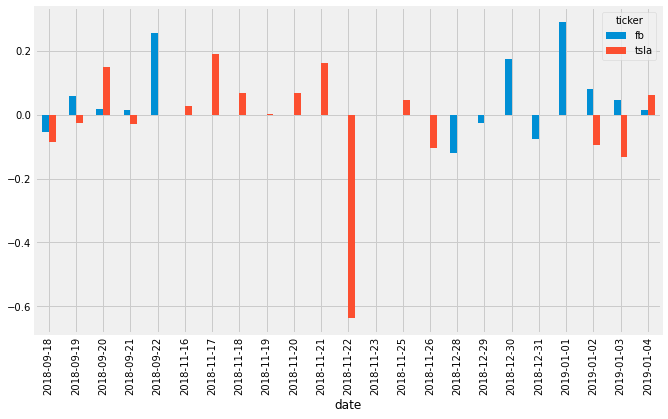

In [27]:
plt.style.use("fivethirtyeight")

%matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date', 'ticker']).mean()
# Unstack the column ticker
mean_c = mean_c.unstack('ticker')
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs("compound", axis="columns")
# Plot a bar chart with pandas
mean_c.plot.bar(figsize = (10, 6));

<h3>There seems to be unusual activity on 2018-11-22 for TSLA</h3>
<p>It seems there are untidy data or repetition in headlines, so let's clean up our data.</p>


In [34]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news.headline.count()
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['headline', 'ticker'])
# Count number of headlines after dropping duplicates (store as integer)
num_news_after = scored_news_clean.headline.count()
# Print before and after numbers to get an idea of how we did 

f"Before cleaning: {num_news_before} headlines, After cleaning: {num_news_after} headlines"

'Before cleaning: 500 headlines, After cleaning: 476 headlines'

<h3>Focusing on one single day of one stock</h3>

In [35]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
# Cross-section the fb row
single_day = single_day.xs('fb')
# Select the 3rd of January of 2019
single_day = single_day.loc['2019-01-03']
# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time
# Set the index to time and sort by it
single_day = single_day.set_index('time')
# Sort it
single_day = single_day.sort_index()

In [36]:
single_day

,headline,neg,neu,pos,compound
time,,,,,
06:00:00,Why Internet Censorship Doesnt Work and Never ...,0.000,1.000,0.000,0.0000
08:04:00,"3 Big Stock Charts for Thursday: Medtronic, Fa...",0.000,1.000,0.000,0.0000
09:07:00,"The Zacks Analyst Blog Highlights: Facebook, W...",0.000,0.846,0.154,0.2500
09:12:00,Why The FAANGs Are Crucial To A 2019 Market Rally,0.000,1.000,0.000,0.0000
09:34:00,Apple warning stoking fears of slowdown in Chi...,0.426,0.574,0.000,-0.6369
09:48:00,"Stock Market News For Jan 3, 2019",0.000,1.000,0.000,0.0000
09:58:00,Facebook Falls 3%,0.981,0.019,0.000,-0.9993
10:08:00,Mark Zuckerberg Halts Stock Sales as Facebook ...,0.000,0.784,0.216,0.2960
10:21:00,Facebook Under Fire for Collecting Data From A...,0.231,0.769,0.000,-0.3400


<h3>Visualizing the single day of trading for a single stock</h3>

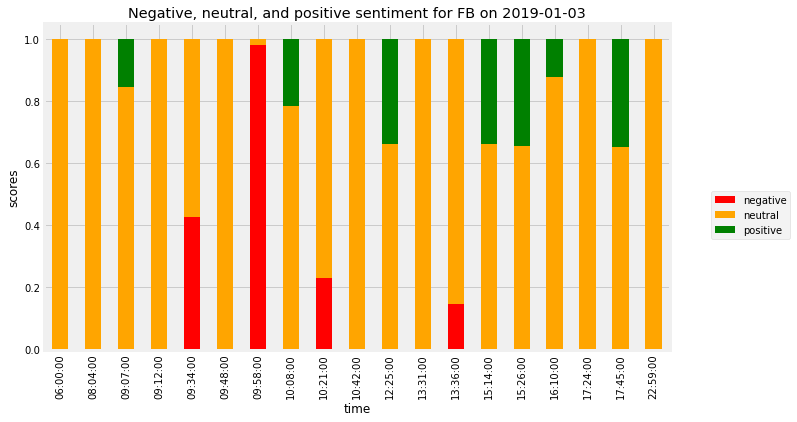

In [37]:
TITLE = "Negative, neutral, and positive sentiment for FB on 2019-01-03"

COLORS = ["red","orange", "green"]

# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['compound', 'headline'], 1)

# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'neutral', 'positive']

# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");